TypeError: 'NoneType' object is not subscriptable

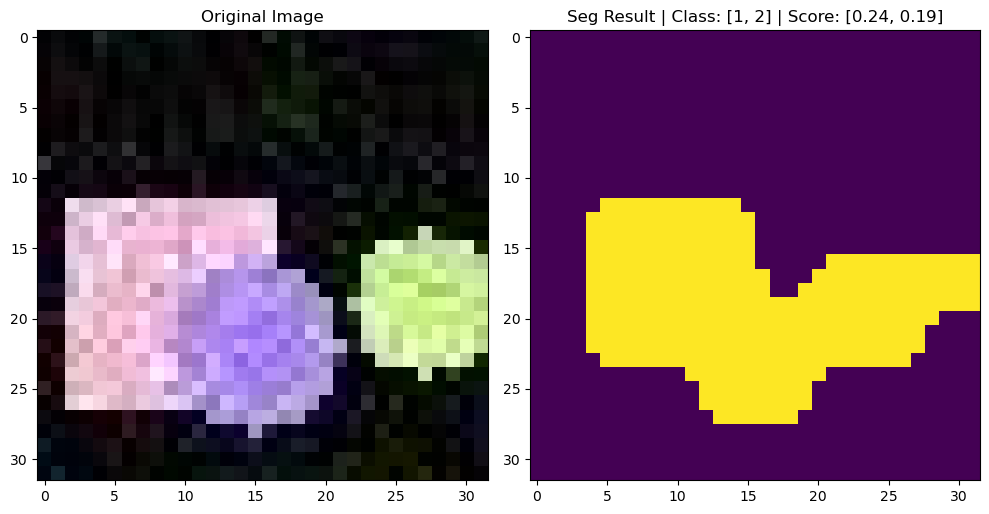

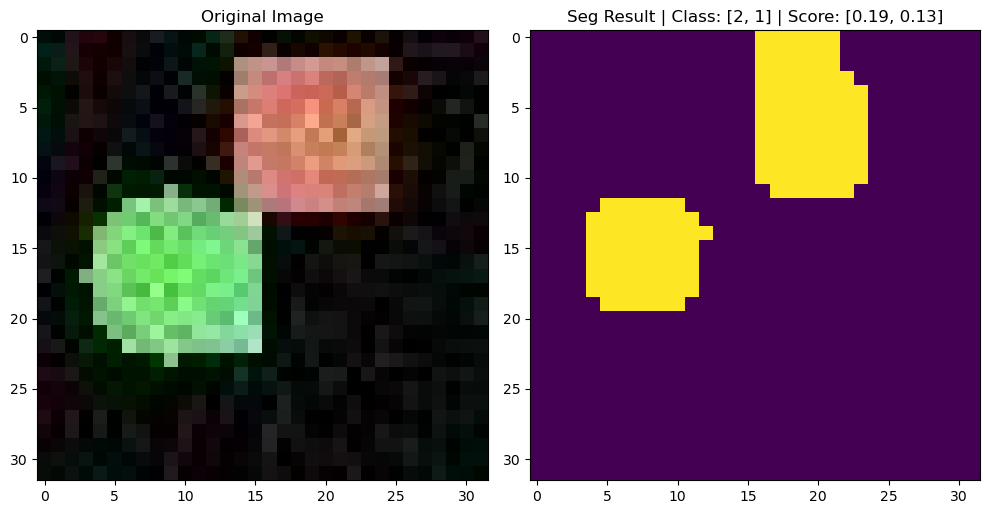

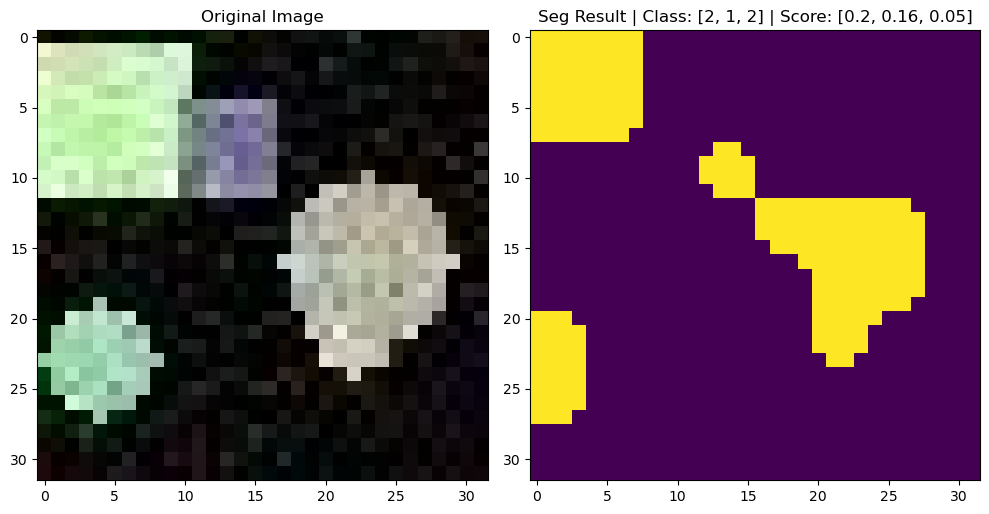

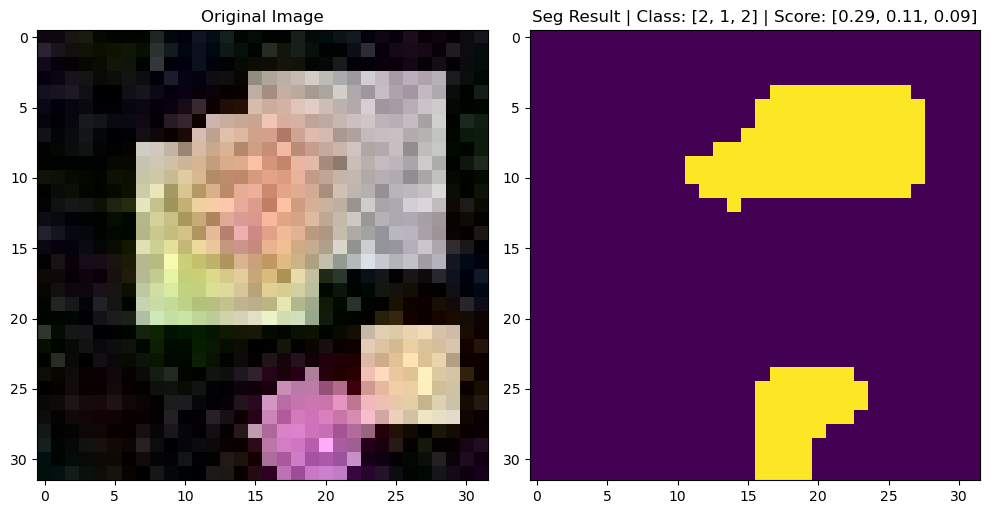

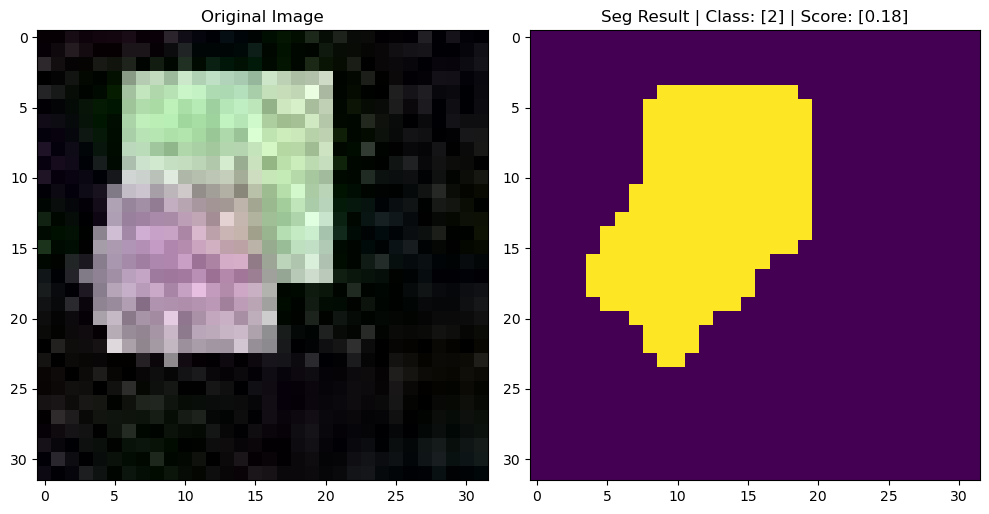

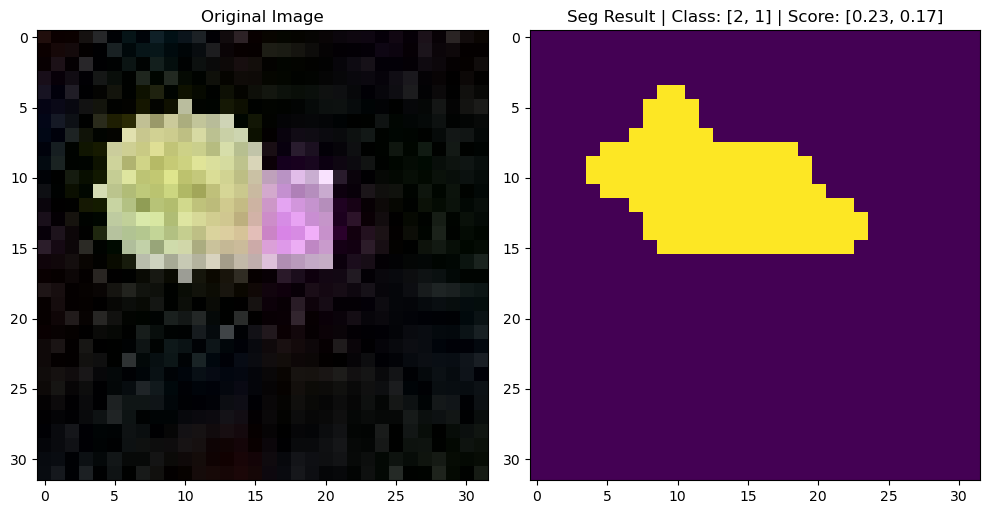

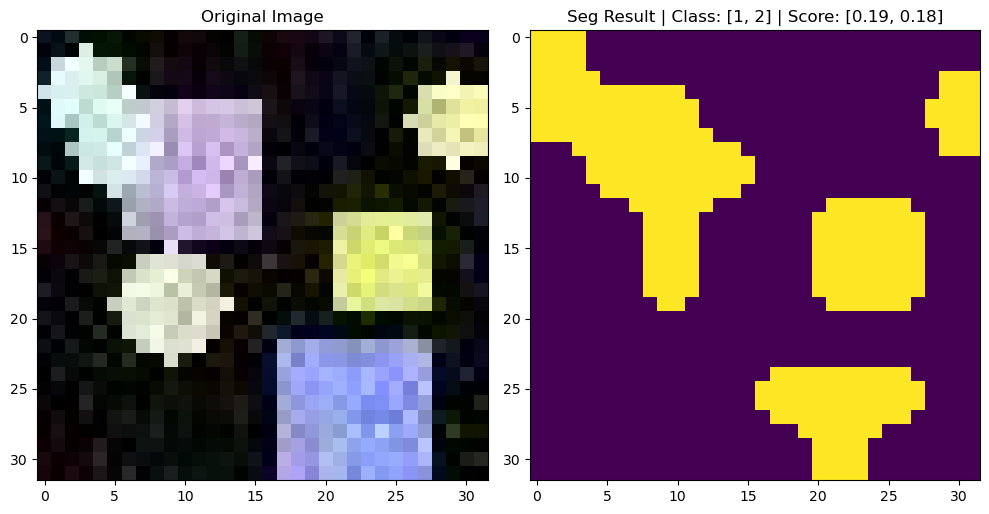

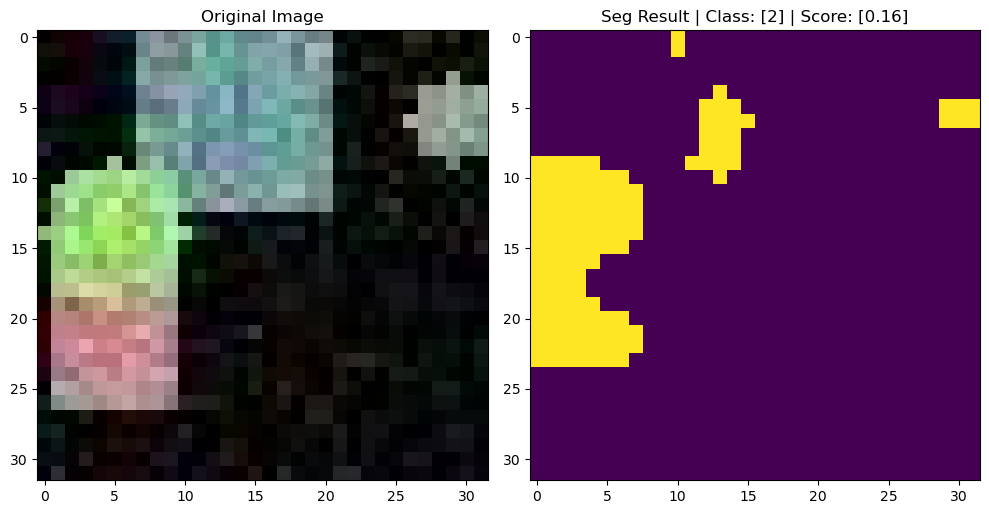

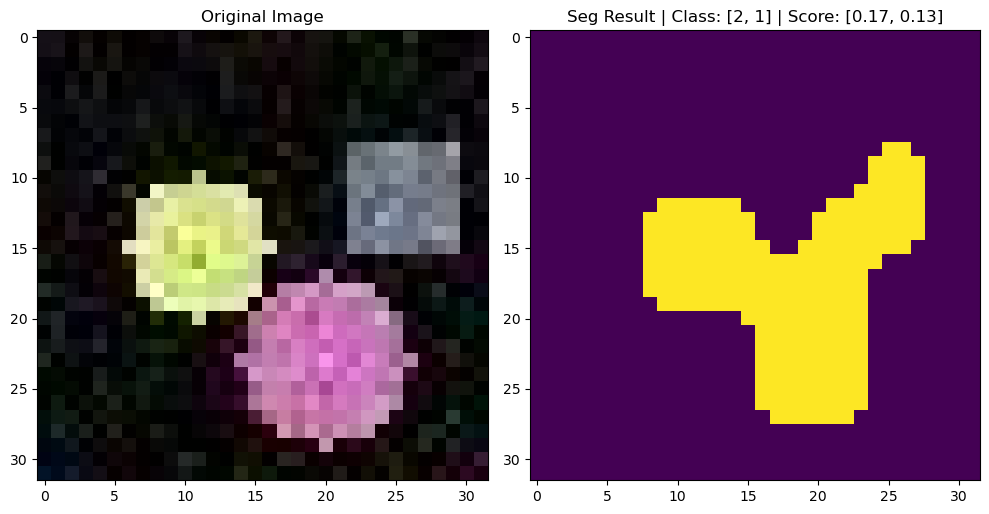

: 

In [1]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt

from data.compose import Compose
from data.config import cfg, process_funcs_dict
from modules.solov2 import SOLOV2

import os
from glob import glob
import warnings 
warnings.filterwarnings("ignore")

def build_process_pipeline(pipeline_confg):
    assert isinstance(pipeline_confg, list)
    process_pipelines = []
    for pipconfig in pipeline_confg:
        assert isinstance(pipconfig, dict) and 'type' in pipconfig
        args = pipconfig.copy()
        obj_type = args.pop('type')
        if isinstance(obj_type, str):
            process_pipelines.append(process_funcs_dict[obj_type](**args))
    return process_pipelines

class LoadImage(object):
    def __call__(self, results):
        if isinstance(results['img'], str):
            results['filename'] = results['img']
        else:
            results['filename'] = None 
        img = cv.imread(results['img'])
        results['img'] = img
        results['img_shape'] = img.shape
        results['ori_shape'] = img.shape
        return results

def eval(valmodel_weight, data_path):
    test_pipeline = []
    transforms = [
        # dict(type='Resize', keep_ratio=True),
                  dict(type='Normalize', mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True),
                  dict(type='Pad', size_divisor=32),
                  dict(type='ImageToTensor', keys=['img']),
                  dict(type='TestCollect', keys=['img']),
                  ]
    transforms_piplines = build_process_pipeline(transforms)
    Multest = process_funcs_dict['MultiScaleFlipAug'](transforms=transforms_piplines, img_scale=(480, 448), flip=False)


    test_pipeline.append(LoadImage())
    test_pipeline.append(Multest)
    test_pipeline = Compose(test_pipeline)

    model = SOLOV2(cfg, pretrained=valmodel_weight, mode='test')
    model = model.cuda()

    # Process images from data_path
    test_imgpath = data_path + '/*'
    images = glob(test_imgpath)

    for k, imgpath in enumerate(images):
        # Process image through pipeline
        data = test_pipeline(dict(img=imgpath))
        imgs = data['img']
        img = imgs[0].cuda().unsqueeze(0)
        img_info = data['img_metas']
        
        # Run model inference
        with torch.no_grad():
            seg_result = model.forward(img=[img], img_meta=[img_info], return_loss=False)
        
        # Get results
        raw_img = cv.cvtColor(cv.imread(imgpath), cv.COLOR_BGR2RGB)
        seg_img = seg_result[0][0][0].cpu().numpy()
        classes = [cfg.label[i.item()] for i in seg_result[0][1][:3]]
        scores = [round(i.item(), 2) for i in seg_result[0][2][:3]]
        
        # Visualize and save results
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(raw_img)
        ax[0].set_title(f'Original Image')
        ax[1].imshow(seg_img)
        ax[1].set_title(f'Seg Result | Class: {classes} | Score: {scores}')
        plt.tight_layout()
        
        # Save output
        out_filepath = "results/" + os.path.basename(imgpath)
        plt.savefig(out_filepath)

eval(valmodel_weight='weights/solov2_resnet18_epoch_10.pth', data_path="/home/localssk23/SOLOv2/datasets/dummy_2d/test_imgs")